In [1]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-10-04 15:26:12.431493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O ../../data/cats_and_dogs_filtered.zip -A
!unzip -q ../../data/cats_and_dogs_filtered.zip -d ../../data

wget: option requires an argument -- 'A'
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
replace ../../data/cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
TRAIN_DIR = "../../data/cats_and_dogs_filtered/train"
VAL_DIR = "../../data/cats_and_dogs_filtered/validation"

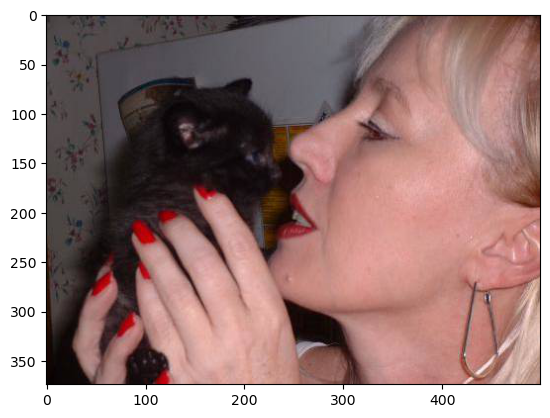

In [ ]:
label = "cats"
train_sample_fn = os.listdir(os.path.join(TRAIN_DIR, label))[0]
train_sample_path = os.path.join(TRAIN_DIR, label, train_sample_fn)

img = Image.open(train_sample_path)
img_data = np.asarray(img)
plt.imshow(img_data);

In [ ]:
IMG_SIZE = (224, 224)
INP_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 64

def gen_new_data(data_folder, augmented=True):
  if augmented:
    data_gen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  horizontal_flip=True)
  else:
    data_gen = ImageDataGenerator(rescale=1./255)

  data = data_gen.flow_from_directory(
      data_folder,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode="binary",
  )
  return data

In [ ]:
INP_SHAPE

(224, 224, 3)

In [ ]:
ds_train = gen_new_data(TRAIN_DIR, augmented=True)
ds_val = gen_new_data(VAL_DIR, augmented=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Resizing

## ResNet

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

resnet = Sequential()
resnet.add(Resizing(224, 224, input_shape=INP_SHAPE))
resnet.add(hub.KerasLayer(resnet_url, trainable=False))
resnet.add(Dense(1, activation="sigmoid"))
resnet.summary()

2023-10-04 15:13:34.959219: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
INP_SHAPE

(224, 224, 3)

In [ ]:
resnet.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
resnet_history = resnet.fit(ds_train, epochs=15, validation_data=ds_val)

Epoch 1/15


2023-10-04 15:13:40.509595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-04 15:13:44.312750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/zeros_like_73/StatefulPartitionedCall' with dtype float and shape [?,1,1,2048]
	 [[{{node gradients/zeros_like_73/StatefulPartitionedCall}}]]
2023-10-04 15:13:44.318951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tens

 4/32 [==>...........................] - ETA: 1:07 - loss: 0.6905 - acc: 0.5962

## MobileNetV2

In [ ]:
from tensorflow.keras.layers import InputLayer


In [ ]:
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

mobilenet = Sequential()
mobilenet.add(InputLayer(input_shape=INP_SHAPE))
mobilenet.add(hub.KerasLayer(mobilenet_url, trainable=False))
mobilenet.add(Dense(1, activation="sigmoid"))
mobilenet.summary()

In [ ]:
mobilenet.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
mobilenet_history = mobilenet.fit(ds_train, epochs=20, validation_data=ds_val)

In [ ]:
mobilenet.save('mobilenet.h5')

## Inception Net

In [ ]:
inceptionnet_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/4"

inceptionnet = Sequential()
inceptionnet.add(InputLayer(input_shape=INP_SHAPE))
inceptionnet.add(hub.KerasLayer(mobilenet_url, trainable=False))
inceptionnet.add(Dense(1, activation="sigmoid"))
inceptionnet.summary()

In [ ]:
inceptionnet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
inceptionnet_history = inceptionnet.fit(ds_train, epochs=15, validation_data=ds_val)

In [ ]:
import numpy as np
import sklearn
x = np.array([2, 0, 0])
y = np.array([2, 0, 4])
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(x, y)

In [ ]:
import numpy as np
import sklearn
x = np.array([1, 1, 0])
y = np.array([1, 1, 1, 1])
x.dot(y) / (np.sqrt(sum(x**2)) * np.sqrt(sum(y**2)))

In [ ]:
3 / (np.sqrt(10) * (np.sqrt(3)))